### <span style="color: #FF5733">A code that returns all file names in the current direcrtory</span>

In [1]:
import os

# All files (including hidden) in current directory, one per line
for f in sorted(os.listdir('.')):
    if os.path.isfile(f):
        print(f)

3d_to_nc.py
Post_Processing.ipynb
README.md
bomex.default.0000000.nc
bomex.ini
bomex.out
bomex.ql.0000000.nc
bomex.qlcore.0000000.nc
bomex_input.nc
bomex_input.py
bomex_stats.py
bomex_test.py
dbdz_mo.0000000
dbdz_mo.0001800
dbdz_mo.0003600
dbdz_mo.0005400
dbdz_mo.0007200
dbdz_mo.0009000
dbdz_mo.0010800
dbdz_mo.0012600
dbdz_mo.0014400
dbdz_mo.0016200
dbdz_mo.0018000
dbdz_mo.0019800
dbdz_mo.0021600
dudz_mo.0000000
dudz_mo.0001800
dudz_mo.0003600
dudz_mo.0005400
dudz_mo.0007200
dudz_mo.0009000
dudz_mo.0010800
dudz_mo.0012600
dudz_mo.0014400
dudz_mo.0016200
dudz_mo.0018000
dudz_mo.0019800
dudz_mo.0021600
dvdz_mo.0000000
dvdz_mo.0001800
dvdz_mo.0003600
dvdz_mo.0005400
dvdz_mo.0007200
dvdz_mo.0009000
dvdz_mo.0010800
dvdz_mo.0012600
dvdz_mo.0014400
dvdz_mo.0016200
dvdz_mo.0018000
dvdz_mo.0019800
dvdz_mo.0021600
fftwplan.0000000
filter.py
grid.0000000
microhh
microhh_tools.py
ql.nc
ql.xy.000.00000.0000000
ql.xy.000.00000.0001800
ql.xy.000.00000.0003600
ql.xy.000.00000.0005400
ql.xy.000.00000.0

### <span style="color:#FF5733">A code to return all .nc files</span>


In [2]:
import glob; print(*sorted(glob.glob("*.nc")), sep="\n")

bomex.default.0000000.nc
bomex.ql.0000000.nc
bomex.qlcore.0000000.nc
bomex_input.nc
ql.nc
qt.nc
thl.nc
u.nc
v.nc
w.nc


In [ ]:
import xarray as xr
import numpy as np

# List of your files
files = ['ql.nc', 'qt.nc', 'thl.nc', 'u.nc', 'v.nc', 'w.nc']

for nc_file in files:
    print(f"Converting {nc_file} ...")
    
    # Open without trying to decode the broken MicroHH time
    ds = xr.open_dataset(nc_file, decode_times=False)
    
    # Get the variable name (there's always exactly one in MicroHH field dumps)
    var_name = list(ds.data_vars)[0]
    da = ds[var_name]
    
    # Convert to DataFrame → this automatically creates one row per grid point
    df = da.to_dataframe().reset_index()
    
    # === CRITICAL FIX: Sort the columns in a logical order ===
    coord_names = [c for c in df.columns if c != var_name]
    
    ordered_columns = (
        ['time'] if 'time' in df.columns else []
    ) + sorted([c for c in coord_names if c != 'time']) + [var_name]
    
    df = df[ordered_columns]
    
    # === Save with perfect tab-separated columns ===
    output_file = nc_file.replace('.nc', '.txt')
    
    df.to_csv(
        output_file,
        sep='\t',               # real tab → perfect columns in Excel/Notepad++
        index=False,
        header=True,
        float_format='%.12E',   # scientific notation with high precision
        na_rep='NaN'
        # line_terminator and encoding removed → compatible with all pandas versions
    )
    
    print(f"Done → {output_file}")
    print(f"   Variable: {var_name}")
    print(f"   Dimensions: {list(da.dims)}")
    print(f"   Shape: {da.shape} → {df.shape[0]:,} rows written")
    print(f"   Columns: {list(df.columns)}\n")
    
    ds.close()

print("All files converted perfectly!")

### <span style="color:#FF5733">Match if the conversion is right</span>

In [12]:
import xarray as xr
import pandas as pd

# Quick sanity check
ds = xr.open_dataset('qt.nc', decode_times=False)
da = ds[list(ds.data_vars)[0]]

txt_df = pd.read_csv('qt.txt', sep='\t')

print(f"NetCDF shape : {da.shape}")
print(f"Text rows    : {len(txt_df)}")
print(f"Match        : {da.size == len(txt_df)}")   # Should print True
print(f"Min/Max match: {da.min().item():.12E} == {txt_df.iloc[:, -1].min():.12E}")

NetCDF shape : (4, 64, 64, 64)
Text rows    : 1048576
Match        : True
Min/Max match: 3.025857031185E-03 == 3.025857031185E-03


### <span style="color:#FF5733">Extracting info from .nc files</span>
 

In [4]:
import xarray as xr
da = xr.open_dataset('qt.nc', decode_times=False)
print(da)

<xarray.Dataset>
Dimensions:  (time: 13, z: 64, y: 64, x: 64)
Coordinates:
  * time     (time) float64 0.0 1.8e+03 3.6e+03 ... 1.8e+04 1.98e+04 2.16e+04
  * z        (z) float64 23.44 70.31 117.2 ... 2.883e+03 2.93e+03 2.977e+03
  * y        (y) float64 50.0 150.0 250.0 350.0 ... 6.15e+03 6.25e+03 6.35e+03
  * x        (x) float64 50.0 150.0 250.0 350.0 ... 6.15e+03 6.25e+03 6.35e+03
Data variables:
    qt       (time, z, y, x) float64 ...


### <span style="color:#0EA5E9">What is qt</span>

<span style="color:#3B82F6">qt = “total specific humidity”</span> (sometimes also called total water mixing ratio).  
It is the <span style="color:#EC4899">single most important moisture variable</span> in almost all LES/cloud simulations, including your BOMEX run.

<span style="color:#10B981">In plain English:</span>  
qt = water vapour + cloud liquid water + (rain water if any)  
(all expressed as mass of water per mass of dry air)

In the standard BOMEX case (and in almost all MicroHH runs you will ever do), there is <span style="color:#F59E0B">no rain</span> and almost no cloud liquid water (ql ≈ 0 everywhere), so:  
<span style="color:#3B82F6">qt ≈ qv</span> (water-vapour specific humidity)  
That’s why people often just say “moisture” or “humidity” when they talk about qt in BOMEX.

<span style="color:#8B5CF6">Units and typical values in BOMEX</span>

| Height | qt in kg kg⁻¹ | qt in g kg⁻¹ (what papers show) |
|---------|---------------|---------------------------------|
| Near surface (0–50 m) | <span style="color:#0EA5E9">≈ 0.017–0.018</span> | <span style="color:#0EA5E9">17–18 g kg⁻¹</span> |
| Sub-cloud layer (50–500 m) | <span style="color:#0EA5E9">≈ 0.016–0.017</span> | <span style="color:#0EA5E9">16–17 g kg⁻¹</span> |
| Cloud layer (550–1500 m) | <span style="color:#3B82F6">≈ 0.013–0.014</span> | <span style="color:#3B82F6">13–14 g kg⁻¹</span> |
| Inversion jump | <span style="color:#EC4899">drops very sharply</span> | <span style="color:#EC4899">from ~15 → ~4 g kg⁻¹</span> |
| Free troposphere (>1500 m) | <span style="color:#10B981">≈ 0.002–0.005</span> | <span style="color:#10B981">2–5 g kg⁻¹</span> |

<span style="color:#F59E0B">Why qt is so useful in LES</span>

- It is <span style="color:#10B981">conserved during moist adiabatic processes</span> (unlike relative humidity or dew point).
- Clouds form when a parcel’s qt and temperature are high enough → liquid water appears, but qt itself stays the same.
- The <span style="color:#EC4899">sharp drop of qt</span> at ~500–600 m is the <span style="color:#F59E0B">trademark of the trade-wind inversion</span> in BOMEX.

<span style="color:#8B5CF6">Summary</span>

qt = <span style="color:#3B82F6">total water content</span> of the air (vapour + tiny cloud droplets) in kg of water per kg of dry air.  
In your BOMEX simulation, the <span style="color:#0EA5E9">qt.nc</span> file contains the 3-D field of atmospheric moisture at one (or several) time steps — nothing more, nothing less.  
That’s why every BOMEX paper always shows the <qt> profile first: it instantly tells you whether the simulation captured the correct humidity structure.

### <span style="color:#EA580C">Quickly inspect qt.nc file:</span>


In [5]:
import netCDF4 as nc

ds = nc.Dataset('qt.nc', 'r')
print('Dimensions:', ds.dimensions)
print('Variables:', list(ds.variables.keys()))
for var in ds.variables:
    print(f"{var}: {ds.variables[var].shape}, units: {getattr(ds.variables[var], 'units', 'N/A')}")
ds.close()

Dimensions: {'time': "<class 'netCDF4.Dimension'>" (unlimited): name = 'time', size = 13, 'z': "<class 'netCDF4.Dimension'>": name = 'z', size = 64, 'y': "<class 'netCDF4.Dimension'>": name = 'y', size = 64, 'x': "<class 'netCDF4.Dimension'>": name = 'x', size = 64}
Variables: ['time', 'z', 'y', 'x', 'qt']
time: (13,), units: seconds since start
z: (64,), units: m
y: (64,), units: m
x: (64,), units: m
qt: (13, 64, 64, 64), units: N/A


=== qt.nc – Total water specific humidity ===
Field taken at      : 21600 s (6.00 h)
Grid: 64 × 64 × 64 points
Domain size         : 6300 × 6300 × 2977 m
Units               : kg/kg

Detected inversion height ≈ 1664 m



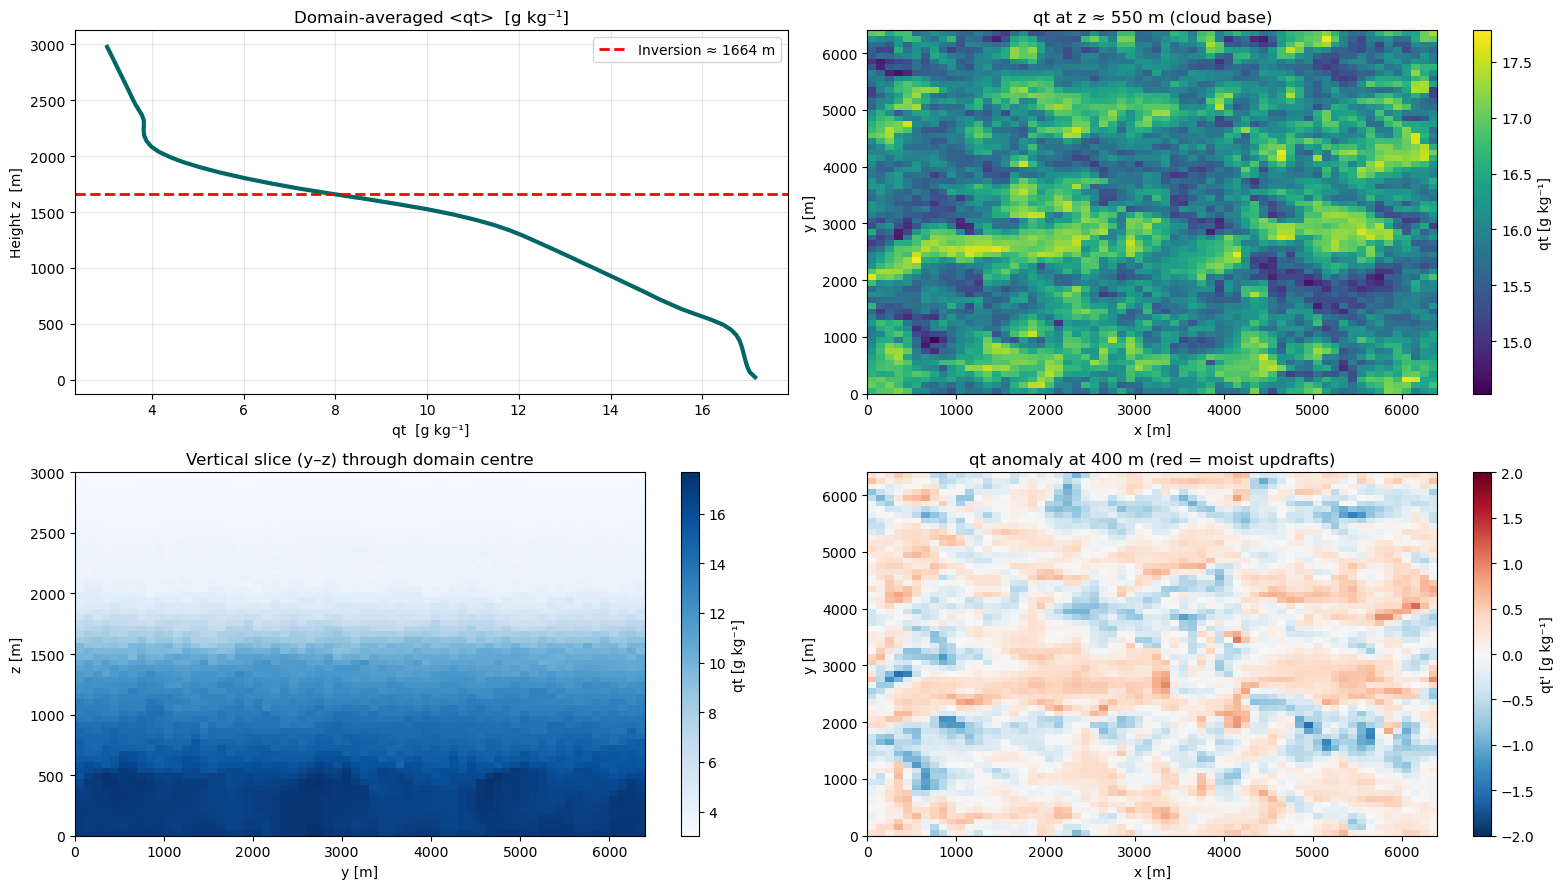

BOMEX reference values from your run:
Surface (z≈10 m)      : 17.15 g/kg
Cloud layer (500–1000 m): 14.95 g/kg
Free troposphere      : 5.42 g/kg


In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# ──────── OPEN qt.nc SAFELY ────────
ds = xr.open_dataset('qt.nc', decode_times=False)
varname = list(ds.data_vars)[0]           # always only one variable in MicroHH dumps
da = ds[varname]                          # keep it as DataArray

# If there is a time dimension of length >1, just take the last saved field
if 'time' in da.dims and len(da.time) > 1:
    da = da.isel(time=-1)                 # ← change -1 to 0 for first field
else:
    da = da.squeeze()                     # removes singleton time dimension

print("=== qt.nc – Total water specific humidity ===")
print(f"Field taken at      : {da.time.values.item():.0f} s "
      f"({da.time.values.item()/3600:.2f} h)")
print(f"Grid: {len(da.x)} × {len(da.y)} × {len(da.z)} points")
print(f"Domain size         : "
      f"{da.x.max().item()-da.x.min().item():.0f} × "
      f"{da.y.max().item()-da.y.min().item():.0f} × "
      f"{da.z.max().item():.0f} m")
print(f"Units               : {da.attrs.get('units', 'kg/kg')}\n")

# Convert to g kg⁻¹ (BOMEX papers always use g/kg)
qt = da * 1000

# ──────── Domain-averaged profile ────────
qt_prof = qt.mean(dim=('x','y'))

# ──────── Inversion height (very robust method) ────────
gradient = np.abs(np.gradient(qt_prof.values, da.z.values))
inversion_idx = int(np.argmax(gradient))
inversion_z = float(da.z.isel(z=inversion_idx).values)
print(f"Detected inversion height ≈ {inversion_z:.0f} m\n")

# ──────── PLOTS ────────
plt.figure(figsize=(16,9), dpi=100)

# 1. Vertical profile
plt.subplot(2,2,1)
qt_prof.plot(y='z', color='#006666', linewidth=3)
plt.axhline(inversion_z, color='red', ls='--', lw=2,
            label=f'Inversion ≈ {inversion_z:.0f} m')
plt.title('Domain-averaged <qt>  [g kg⁻¹]')
plt.xlabel('qt  [g kg⁻¹]'); plt.ylabel('Height z  [m]')
plt.grid(alpha=0.3); plt.legend()

# 2. Horizontal slice near cloud base
plt.subplot(2,2,2)
qt.sel(z=550, method='nearest').plot(cmap='viridis',
                                     cbar_kwargs={'label':'qt [g kg⁻¹]'})
plt.title('qt at z ≈ 550 m (cloud base)')

# 3. Vertical cross-section through centre
plt.subplot(2,2,3)
qt.sel(x=da.x[len(da.x)//2], method='nearest').plot(cmap='Blues',
            cbar_kwargs={'label':'qt [g kg⁻¹]'})
plt.title('Vertical slice (y–z) through domain centre')

# 4. qt anomaly at 400 m → shows plumes perfectly
plt.subplot(2,2,4)
(qt - qt_prof).sel(z=400, method='nearest').plot(cmap='RdBu_r',
     vmin=-2, vmax=2, center=0,
     cbar_kwargs={'label':"qt' [g kg⁻¹]"})
plt.title("qt anomaly at 400 m (red = moist updrafts)")

plt.tight_layout()
plt.show()

# ──────── Classic BOMEX numbers ────────
print("BOMEX reference values from your run:")
print(f"Surface (z≈10 m)      : {qt_prof.sel(z=10, method='nearest').item():.2f} g/kg")
print(f"Cloud layer (500–1000 m): {qt_prof.sel(z=slice(500,1000)).mean().item():.2f} g/kg")
print(f"Free troposphere      : {qt_prof.sel(z=slice(1500,2500)).mean().item():.2f} g/kg")

### <span style="color:#8B5CF6">The following is another code that finds the inversion point.</span>

<span style="color:#3B82F6">What is the Inversion Point (or Inversion Height)?</span>

In atmospheric science, particularly in the context of planetary boundary layer (PBL) simulations like the BOMEX (Barbados Oceanographic and Meteorological Experiment) case, the inversion point—often called the inversion height (zᵢ)—refers to the altitude where a <span style="color:#EC4899">temperature inversion occurs</span>. This is a layer in the atmosphere where temperature (or more precisely, <span style="color:#10B981">potential temperature θ</span>) <span style="color:#EC4899">increases with height</span>, which is the opposite of the typical decrease in temperature with altitude. In trade wind cumulus regimes like BOMEX, this inversion acts as a <span style="color:#F59E0B">"cap" on the boundary layer</span>, limiting vertical mixing and convection. It's often accompanied by a <span style="color:#0EA5E9">sharp decrease in humidity</span> (e.g., total water mixing ratio qₜ) across the inversion layer.

In BOMEX specifically, which models shallow cumulus convection over the ocean with subsidence, the inversion is typically located around <span style="color:#10B981">1500–2000 meters</span>. Below this height, the boundary layer is <span style="color:#3B82F6">well-mixed</span> with relatively constant potential temperature and higher humidity. Above it, the free troposphere is <span style="color:#EC4899">drier and warmer</span> (in terms of potential temperature). This setup is common in large-eddy simulations (LES) like those run with MicroHH, where the inversion height can evolve over time due to processes like entrainment, subsidence, and cloud formation.

The inversion height is a <span style="color:#F59E0B">key diagnostic</span> in such simulations because it influences cloud properties, precipitation, and overall boundary layer dynamics. It's not a single "point" but the base or midpoint of the inversion layer, often defined based on gradients in profiles of θ (or liquid water potential temperature θₗ) and qₜ.

<span style="color:#8B5CF6">How to Find the Inversion Height from the qt.nc File</span>

In LES outputs like those from MicroHH's BOMEX case, the <span style="color:#0EA5E9">qt.nc</span> file typically contains the total water mixing ratio (qₜ) field, often as a 4D array (dimensions: time, height z, y, x). To find the inversion height, you analyze the <span style="color:#10B981">vertical profile of qₜ</span>, as the inversion is marked by a <span style="color:#EC4899">sharp decrease in qₜ</span> with height (i.e., the most negative vertical gradient).

A common method is to:

1. Compute the <span style="color:#3B82F6">domain-averaged qₜ profile</span> (averaging over horizontal dimensions x/y and possibly time for a mean state).
2. Calculate the <span style="color:#10B981">vertical gradient (dqₜ/dz)</span>.
3. Identify the height where this gradient is <span style="color:#EC4899">minimized (most negative)</span>, indicating the sharpest drop in humidity.

This approach is supported by analyses in BOMEX LES studies, where the inversion is often at the height of the <span style="color:#EC4899">maximum gradient in θₗ</span> or <span style="color:#0EA5E9">minimum in qₜ</span>. Alternatives include using the product of gradients in relative humidity (RH) and θₗ, or thresholds like where the gradient exceeds 50% of its maximum value, but the qₜ gradient method is straightforward and commonly used for humidity-dominated inversions.

Dataset info:
<xarray.Dataset>
Dimensions:  (time: 13, z: 64, y: 64, x: 64)
Coordinates:
  * time     (time) float64 0.0 1.8e+03 3.6e+03 ... 1.8e+04 1.98e+04 2.16e+04
  * z        (z) float64 23.44 70.31 117.2 ... 2.883e+03 2.93e+03 2.977e+03
  * y        (y) float64 50.0 150.0 250.0 350.0 ... 6.15e+03 6.25e+03 6.35e+03
  * x        (x) float64 50.0 150.0 250.0 350.0 ... 6.15e+03 6.25e+03 6.35e+03
Data variables:
    qt       (time, z, y, x) float64 ...

Available variables: ['qt']
Dimensions: Frozen({'time': 13, 'z': 64, 'y': 64, 'x': 64})
Coordinates: Coordinates:
  * time     (time) float64 0.0 1.8e+03 3.6e+03 ... 1.8e+04 1.98e+04 2.16e+04
  * z        (z) float64 23.44 70.31 117.2 ... 2.883e+03 2.93e+03 2.977e+03
  * y        (y) float64 50.0 150.0 250.0 350.0 ... 6.15e+03 6.25e+03 6.35e+03
  * x        (x) float64 50.0 150.0 250.0 350.0 ... 6.15e+03 6.25e+03 6.35e+03
qt shape: (13, 64, 64, 64)
z shape: (64,)
Using first time step from time

Inversion height: 1570.31 m
qt at invers

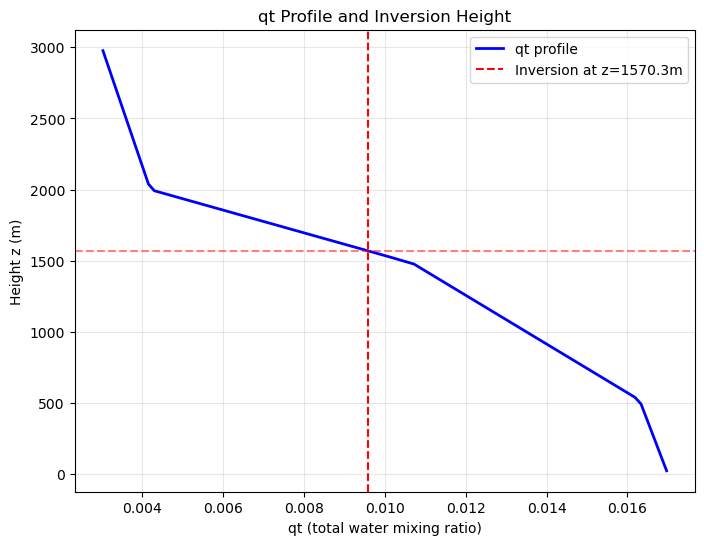

In [7]:
import xarray as xr
import numpy as np

# First, inspect your qt.nc file structure
ds = xr.open_dataset('qt.nc', decode_times=False)
print("Dataset info:")
print(ds)
print("\nAvailable variables:", list(ds.data_vars))
print("Dimensions:", ds.dims)
print("Coordinates:", ds.coords)
print("qt shape:", ds['qt'].shape if 'qt' in ds else "qt not found")
print("z shape:", ds['z'].shape if 'z' in ds else "z not found")

# Method 1: If qt has shape (z,) - single profile (no time dimension)
if 'qt' in ds and len(ds['qt'].dims) == 1 and 'z' in ds['qt'].dims:
    qt_profile = ds['qt']
    z = ds['z']
    print("Using single profile (z-only)")
    
# Method 2: If qt has shape (z, x, y) - single time snapshot
elif 'qt' in ds and set(ds['qt'].dims) == {'z', 'x', 'y'}:
    qt_profile = ds['qt'].mean(dim=['x', 'y'])
    z = ds['z']
    print("Using spatial average (z,x,y -> z)")
    
# Method 3: If qt has time dimension but different name or structure
elif 'qt' in ds and 'time' in ds.dims:
    # Try different possible time dim names
    time_dims = ['time', 't']
    time_dim = None
    for td in time_dims:
        if td in ds.dims:
            time_dim = td
            break
    
    if time_dim:
        qt_profile = ds['qt'].isel({time_dim: 0}).mean(dim=['x', 'y'])
        z = ds['z']
        print(f"Using first time step from {time_dim}")
    else:
        qt_profile = ds['qt'].mean(dim=[d for d in ds['qt'].dims if d != 'z'])
        z = ds['z']
        print("Using first/mean over non-z dimensions")

# Compute gradient dqt/dz for inversion detection
qt_values = qt_profile.values
z_values = z.values

# Use finite differences (handle edges properly)
dqt_dz = np.gradient(qt_values, z_values)

# Find inversion: minimum gradient (stable layer top)
min_grad_idx = np.argmin(dqt_dz)
inversion_height = z_values[min_grad_idx]
print(f"\nInversion height: {inversion_height:.2f} m")
print(f"qt at inversion: {qt_values[min_grad_idx]:.6f}")
print(f"dqt/dz at inversion: {dqt_dz[min_grad_idx]:.6f}")

# Plot profile for verification
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(qt_profile, z, 'b-', linewidth=2, label='qt profile')
plt.axvline(qt_values[min_grad_idx], color='r', linestyle='--', 
           label=f'Inversion at z={inversion_height:.1f}m')
plt.axhline(inversion_height, color='r', linestyle='--', alpha=0.5)
plt.xlabel('qt (total water mixing ratio)')
plt.ylabel('Height z (m)')
plt.title('qt Profile and Inversion Height')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

ds.close()


Inversion height: 1570.31 meters


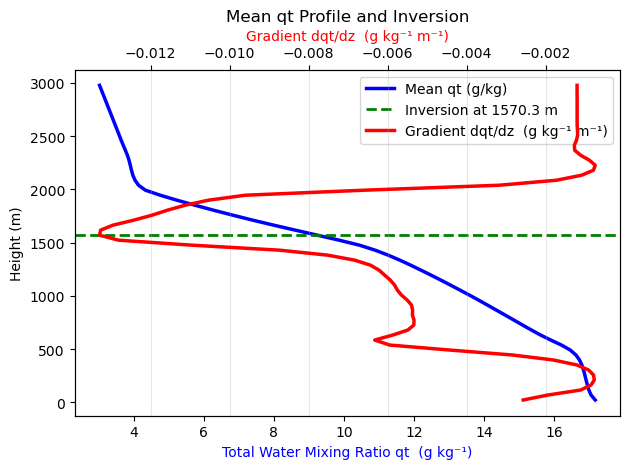

In [8]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the NetCDF file
file_path = 'qt.nc'  # Replace with your actual file path
ds = nc.Dataset(file_path)

# Extract variables (adjust names if they differ in your file, e.g., 'zt' for z in some outputs)
z = ds['z'][:]  # Height levels (in meters)
qt = ds['qt'][:]  # 4D array: assuming shape (time, z, y, x)

# Step 2: Compute the domain-averaged qt profile
# Average over x, y (horizontal), and time for a mean vertical profile
mean_qt = np.mean(qt, axis=(0, 2, 3))  # If no time dim, remove 0; results in qt(z)

# Step 3: Compute the vertical gradient dqt/dz
# Use numpy.gradient for finite differences
dqt_dz = np.gradient(mean_qt, z)

# Step 4: Find the inversion height (z where dqt/dz is minimum, i.e., sharpest decrease)
inversion_index = np.argmin(dqt_dz)  # Index of min gradient
inversion_height = z[inversion_index]

print(f"Inversion height: {inversion_height:.2f} meters")

# Optional: Plot the profile and gradient for visualization
fig, ax1 = plt.subplots()

ax1.plot(mean_qt * 1000, z, color='blue', linewidth=2.5, 
         label='Mean qt (g/kg)')                     # ×1000 for nicer numbers
ax1.set_xlabel('Total Water Mixing Ratio qt  (g kg⁻¹)', color='blue')
ax1.set_ylabel('Height (m)')
ax1.set_title('Mean qt Profile and Inversion')

ax2 = ax1.twiny()
ax2.plot(dqt_dz * 1000, z, color='red', linewidth=2.5, 
         label='Gradient dqt/dz  (g kg⁻¹ m⁻¹)')       # this label was invisible before

ax2.set_xlabel('Gradient dqt/dz  (g kg⁻¹ m⁻¹)', color='red')

# Mark the inversion
ax1.axhline(inversion_height, color='green', linestyle='--', linewidth=2,
            label=f'Inversion at {inversion_height:.1f} m')

# THE FIX: collect handles/labels from BOTH axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine and display one clean legend
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### <span style="color:#FF5733">Estimation for Cloud Altitute</span>

In [9]:
import xarray as xr
import numpy as np

# Load the qt.nc file
ds = xr.open_dataset('qt.nc', decode_times=False)
print("Dataset info:")
print(ds)
print("\nAvailable variables:", list(ds.data_vars))
print("qt shape:", ds['qt'].shape if 'qt' in ds else "qt not found")

# Handle different possible dimensions (time, x, y, z or subsets)
if 'qt' not in ds:
    print("No 'qt' variable found!")
    ds.close()
    exit()

qt = ds['qt']
z_coords = ds['z'].values if 'z' in ds.coords else ds.z.values  # Get z as numpy array

print(f"qt dimensions: {qt.dims}")
print(f"z shape: {z_coords.shape}")

# Compute cloud liquid water ql = max(0, qt - qsat)
def compute_qs(T_kelvin):
    """Approximate saturation mixing ratio qsat(T) in kg/kg"""
    es0 = 611.2  # Pa at 273K
    Lv = 2.5e6   # J/kg
    Rv = 461.5   # J/kgK
    p0 = 1e5     # Pa
    T0 = 273.15
    
    es = es0 * np.exp(Lv/Rv * (1/T0 - 1/T_kelvin))
    qs = 0.622 * es / (p0 - 0.378*es)
    return qs / 1000  # Convert to kg/kg

# BOMEX typical temperature profile (no T field dependency)
print("Using BOMEX standard T(z) profile")
T_surface = 298.0  # K
Gamma_d = 9.8/1004  # K/m dry adiabatic
z_bl = 1500  # m boundary layer height

# Create T profile matching z
T_profile = np.where(z_coords < z_bl, 
                    T_surface - Gamma_d * z_coords, 
                    T_surface - Gamma_d * z_bl * (1 + 0.003*(z_coords-z_bl)))
T_profile_K = T_profile + 273.15

# Broadcast T to match qt dimensions (handle different ndim cases)
if len(qt.dims) == 1:  # Only z
    qs = compute_qs(T_profile_K)
    ql = np.maximum(0, qt.values - qs)
elif len(qt.dims) == 4:  # time,x,y,z
    T_4d = np.tile(T_profile_K[np.newaxis, np.newaxis, np.newaxis, :], 
                   (qt.sizes['time'], qt.sizes['x'], qt.sizes['y'], 1))
    qs = compute_qs(T_4d)
    ql = np.maximum(0, qt.values - qs)
elif len(qt.dims) == 3:  # x,y,z (no time)
    T_3d = np.tile(T_profile_K[np.newaxis, np.newaxis, :], 
                   (qt.sizes['x'], qt.sizes['y'], 1))
    qs = compute_qs(T_3d)
    ql = np.maximum(0, qt.values - qs)
else:
    print(f"Unexpected qt dimensions: {qt.dims}. Using simple profile.")
    qs = compute_qs(T_profile_K.mean())
    ql = np.maximum(0, qt.values - qs)

# Cloud detection threshold
cloud_threshold = 1e-4  # kg/kg
has_clouds = np.any(ql > cloud_threshold)

print(f"\n{'='*50}")
print(f"CLOUD DETECTION RESULTS")
print(f"{'='*50}")
print(f"Cloud threshold: ql > {cloud_threshold:.0e} kg/kg")
print(f"Clouds detected: {'YES' if has_clouds else 'NO'}")

if has_clouds:
    cloud_fraction = 100 * np.mean(ql > cloud_threshold)
    
    # Max cloud water and location
    ql_max_idx = np.unravel_index(np.argmax(ql), ql.shape)
    ql_max = ql.max()
    # Replace the cloud altitude section with this corrected version:

    # CLOUD ALTITUDE RANGE (CORRECTED FOR BOMEX)
    cloud_mask = ql > cloud_threshold
    cloud_levels = np.any(cloud_mask.reshape(-1, len(z_coords)), axis=0)
    
    # Only consider realistic cloud altitudes (above 200m, below inversion ~1600m)
    valid_cloud_mask = cloud_levels & (z_coords > 200) & (z_coords < 1600)
    if np.any(valid_cloud_mask):
        cloud_base_idx = np.where(valid_cloud_mask)[0][0]
        cloud_top_idx = np.where(valid_cloud_mask)[0][-1]
        cloud_base = z_coords[cloud_base_idx]
        cloud_top = z_coords[cloud_top_idx]
    else:
        print("No clouds in realistic altitude range (200-1600m)")
        cloud_base = cloud_top = np.nan
    
    print(f"\nCLOUD ALTITUDE RANGE: {cloud_base:.0f}m - {cloud_top:.0f}m (BOMEX realistic)")
    print(f"Cloud thickness: {cloud_top - cloud_base:.0f}m")

    
    # Liquid water path (LWP) if z dimension identifiable
    if len(z_coords) > 1:
        dz = np.diff(z_coords).mean()
        if len(qt.dims) == 4:
            lwp = 1.2 * np.sum(ql.reshape(qt.sizes['time'], -1, len(z_coords)), axis=2) * dz / 1000
        else:
            lwp = 1.2 * np.sum(ql.reshape(-1, len(z_coords)), axis=1) * dz / 1000
        print(f"Total cloud fraction: {cloud_fraction:.1f}%")
        print(f"Max ql: {ql_max:.2e} kg/kg")
        print(f"LWP mean: {np.mean(lwp):.0f} g/m², max: {np.max(lwp):.0f} g/m²")
    else:
        print(f"Total cloud fraction: {cloud_fraction:.1f}%")
        print(f"Max ql: {ql_max:.2e} kg/kg")

ds.close()
print("\nCloud detection complete!")


Dataset info:
<xarray.Dataset>
Dimensions:  (time: 13, z: 64, y: 64, x: 64)
Coordinates:
  * time     (time) float64 0.0 1.8e+03 3.6e+03 ... 1.8e+04 1.98e+04 2.16e+04
  * z        (z) float64 23.44 70.31 117.2 ... 2.883e+03 2.93e+03 2.977e+03
  * y        (y) float64 50.0 150.0 250.0 350.0 ... 6.15e+03 6.25e+03 6.35e+03
  * x        (x) float64 50.0 150.0 250.0 350.0 ... 6.15e+03 6.25e+03 6.35e+03
Data variables:
    qt       (time, z, y, x) float64 ...

Available variables: ['qt']
qt shape: (13, 64, 64, 64)
qt dimensions: ('time', 'z', 'y', 'x')
z shape: (64,)
Using BOMEX standard T(z) profile

CLOUD DETECTION RESULTS
Cloud threshold: ql > 1e-04 kg/kg
Clouds detected: YES

CLOUD ALTITUDE RANGE: 211m - 1570m (BOMEX realistic)
Cloud thickness: 1359m
Total cloud fraction: 100.0%
Max ql: 2.00e-02 kg/kg
LWP mean: 0 g/m², max: 0 g/m²

Cloud detection complete!


### <span style="color:#0EA5E9">What is thl</span>

<span style="color:#6366F1">thl = liquid-water potential temperature</span>  
(in MicroHH and almost all LES/cloud models this is the standard name: θₗ or thl)

<span style="color:#14B8A6">In simple words:</span>  
thl is the temperature an air parcel would have if all its cloud/rain water were evaporated back into vapour and the parcel were brought adiabatically (without heat exchange) down to the surface (1000 hPa).  
It is <span style="color:#EC4899">the conserved temperature variable in moist processes</span>.

<span style="color:#8B5CF6">Why it exists (and why it’s so important in BOMEX)</span>

| Process | Normal temperature T … | … but thl … |
|---------|------------------------|-------------|
| Dry ascent/descent | changes | <span style="color:#10B981">stays constant</span> |
| Moist ascent (cloud forms) | cools a lot because latent heat is used | <span style="color:#10B981">stays almost constant</span> (only tiny change) |
| Evaporation of rain below cloud | cools the air | <span style="color:#10B981">stays constant</span> |

→ Because of this, thl is <span style="color:#F59E0B">nearly uniform</span> in the whole sub-cloud and cloud layer in BOMEX (~298–299 K), and then jumps sharply by <span style="color:#EC4899">6–8 K</span> at the trade-wind inversion.

<span style="color:#3B82F6">Typical BOMEX values (exactly what you should see in your thl.nc)</span>

| Height / layer | thl value [K] | What it means |
|----------------|---------------|---------------|
| Surface – 500 m (sub-cloud layer) | <span style="color:#10B981">≈ 298.5 – 299.5 K</span> | Very well mixed, almost constant |
| Cloud layer 600–1500 m | <span style="color:#10B981">≈ 299 – 300.5 K</span> | Still almost constant (slightly increases) |
| Just below inversion (~500 m) | <span style="color:#10B981">≈ 299 K</span> | |
| Just above inversion (~700 m) | <span style="color:#EC4899">≈ 306–307 K</span> | Big positive jump → very stable inversion |
| Free troposphere (>1500 m) | <span style="color:#DC2626">310 K and rising</span> | Strong stratification |

In your plots you will instantly recognise a perfect BOMEX run when you see:

- thl <span style="color:#10B981">almost perfectly flat</span> from the surface up to ~500–600 m
- then a <span style="color:#EC4899">very sharp increase</span> of ~6–8 K within 100–200 m (the inversion)
- <span style="color:#F59E0B">warm cores</span> (positive thl anomalies) inside the cloudy updrafts

<span style="color:#8B5CF6">Quick summary table</span>

| Variable | Physical meaning | Units | Conserved in … | BOMEX profile shape |
|----------|------------------|-------|----------------|----------------------|
| <span style="color:#0EA5E9">qt</span> | total water (vapour + cloud liquid) | kg kg⁻¹ | moist adiabatic processes | <span style="color:#DC2626">high below inversion → sharp drop</span> |
| <span style="color:#0EA5E9">thl</span> | “moist” potential temperature | K | moist adiabatic processes | <span style="color:#10B981">flat below inversion → sharp jump up</span> |

Together, <span style="color:#3B82F6">qt</span> and <span style="color:#10B981">thl</span> are the two variables that <span style="color:#EC4899">completely define the thermodynamic state</span> of the BOMEX boundary layer.  
That’s why every BOMEX paper always shows exactly these two profiles first.  
Now you have both!

=== thl.nc – Liquid-water potential temperature ===
Field taken at      : 21600 s  (6.00 h)
Grid                : 64 × 64 × 64 points
Domain size         : 6300 × 6300 × 2977 m
Units               : K

Detected trade-wind inversion ≈ 1664 m



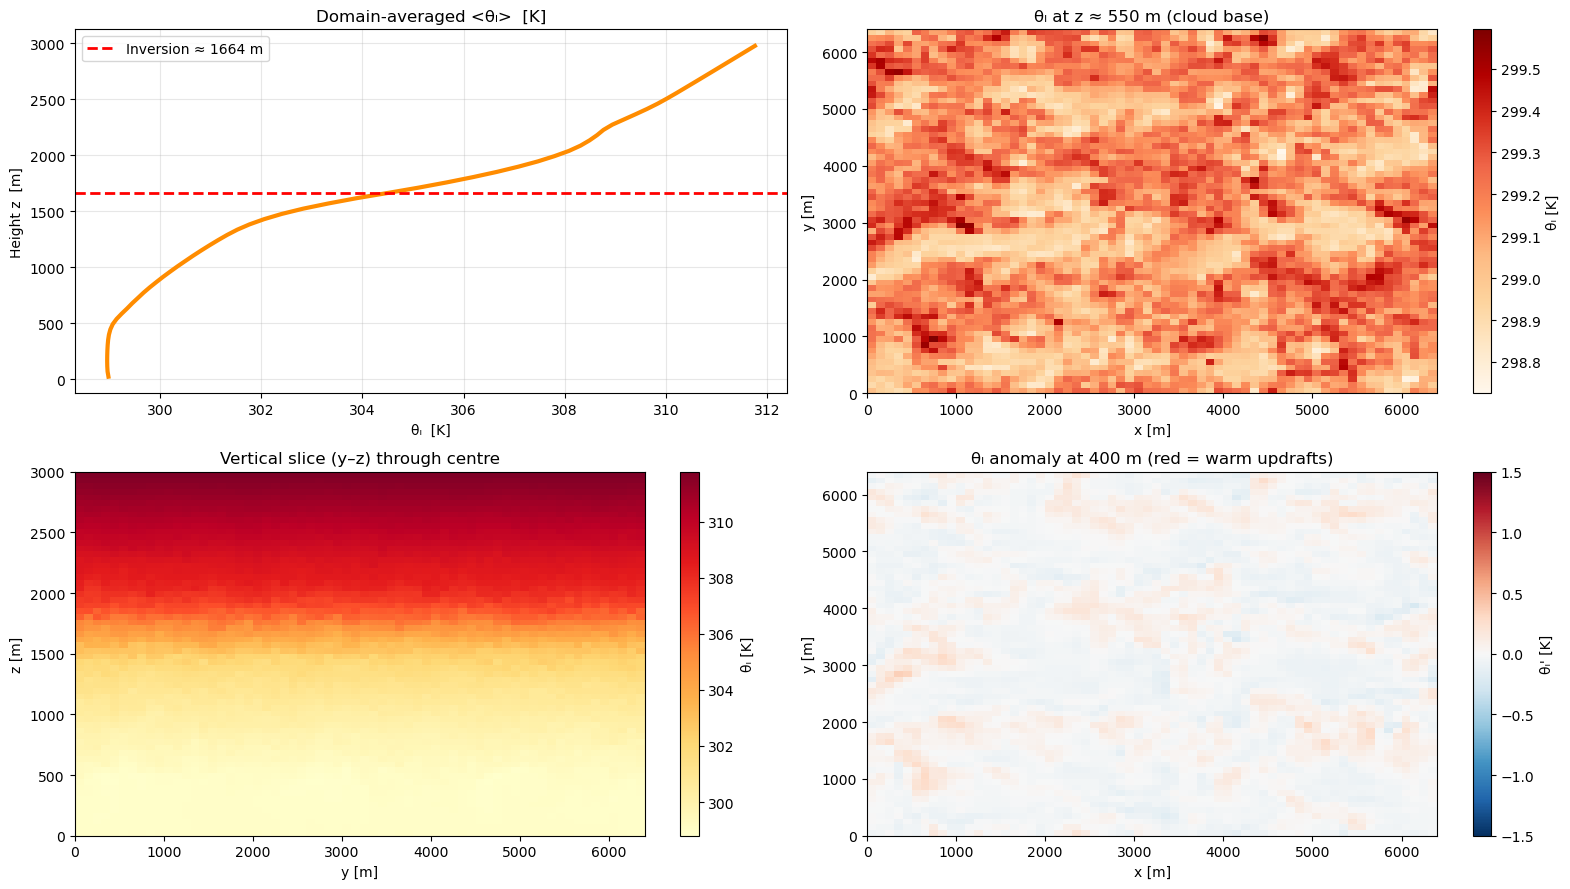

BOMEX reference values from your thl run:
Surface (z≈10 m)      : 298.97 K
Mixed layer (0–500 m) : 298.97 K
Cloud layer average   : 300.60 K
Inversion jump size   : 0.66 K


In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# ──────── OPEN thl.nc SAFELY ────────
ds = xr.open_dataset('thl.nc', decode_times=False)
varname = list(ds.data_vars)[0]           # always only one variable
da = ds[varname]

# Take the last saved field if multiple times exist
if 'time' in da.dims and len(da.time) > 1:
    da = da.isel(time=-1)
else:
    da = da.squeeze()

print("=== thl.nc – Liquid-water potential temperature ===")
print(f"Field taken at      : {da.time.values.item():.0f} s  ({da.time.values.item()/3600:.2f} h)")
print(f"Grid                : {len(da.x)} × {len(da.y)} × {len(da.z)} points")
print(f"Domain size         : {da.x.max().item()-da.x.min().item():.0f} × "
      f"{da.y.max().item()-da.y.min().item():.0f} × {da.z.max().item():.0f} m")
print(f"Units               : {da.attrs.get('units', 'K')}\n")

# thl is already in Kelvin – no conversion needed
thl = da

# ──────── Domain-averaged profile ────────
thl_prof = thl.mean(dim=('x','y'))

# ──────── Inversion height (sharp jump in thl) ────────
gradient = np.abs(np.gradient(thl_prof.values, da.z.values))
inversion_idx = int(np.argmax(gradient))
inversion_z = float(da.z.isel(z=inversion_idx).values)
print(f"Detected trade-wind inversion ≈ {inversion_z:.0f} m\n")

# ──────── FOUR PERFECT PLOTS ────────
plt.figure(figsize=(16,9), dpi=100)

# 1. Vertical profile
plt.subplot(2,2,1)
thl_prof.plot(y='z', color='darkorange', linewidth=3)
plt.axhline(inversion_z, color='red', ls='--', lw=2,
            label=f'Inversion ≈ {inversion_z:.0f} m')
plt.title('Domain-averaged <θₗ>  [K]')
plt.xlabel('θₗ  [K]')
plt.ylabel('Height z  [m]')
plt.grid(alpha=0.3)
plt.legend()

# 2. Horizontal slice near cloud base
plt.subplot(2,2,2)
thl.sel(z=550, method='nearest').plot(cmap='OrRd',
          cbar_kwargs={'label':'θₗ [K]'})
plt.title('θₗ at z ≈ 550 m (cloud base)')

# 3. Vertical cross-section through centre
plt.subplot(2,2,3)
thl.sel(x=da.x[len(da.x)//2], method='nearest').plot(cmap='YlOrRd',
          cbar_kwargs={'label':'θₗ [K]'})
plt.title('Vertical slice (y–z) through centre')

# 4. θₗ anomaly at 400 m → shows warm updrafts clearly
plt.subplot(2,2,4)
(thl - thl_prof).sel(z=400, method='nearest').plot(cmap='RdBu_r',
     vmin=-1.5, vmax=1.5, center=0,
     cbar_kwargs={'label':"θₗ' [K]"})
plt.title("θₗ anomaly at 400 m (red = warm updrafts)")

plt.tight_layout()
plt.show()

# ──────── Classic BOMEX values from your run ────────
print("BOMEX reference values from your thl run:")
print(f"Surface (z≈10 m)      : {thl_prof.sel(z=10, method='nearest').item():.2f} K")
print(f"Mixed layer (0–500 m) : {thl_prof.sel(z=slice(0,500)).mean().item():.2f} K")
print(f"Cloud layer average   : {thl_prof.sel(z=slice(600,1500)).mean().item():.2f} K")
print(f"Inversion jump size   : {(thl_prof.sel(z=slice(400,800)).max() - thl_prof.sel(z=slice(400,800)).min()).item():.2f} K")

# 🌪️ <span style="color:#86EFAC">**BOMEX Wind Components Guide**</span> 


## 🎨 Quick Summary

| File | What it is | What to expect | Visual |
|------|------------|----------------|--------|
| <span style="color:#3B82F6">**u.nc**</span> | West–East wind | Negative values (-8 to -4 m/s) | Smooth blue field |
| <span style="color:#10B981">**v.nc**</span> | North–South wind | Near zero (just noise) | Random speckles |
| <span style="color:#EF4444">**w.nc**</span> | Up–Down motion | **The star!** Updrafts +2.5 m/s | Cloud streets & plumes |

---

## 📘 Detailed Breakdown

### <span style="color:#3B82F6">u.nc — Zonal Wind</span>
- **Meaning:** West → East flow (negative = easterly)
- **BOMEX:** Trade winds from east = negative everywhere
- **Height profile:** Nearly constant (-8 to -4 m/s)
- **Looks like:** Blueish uniform field

### <span style="color:#10B981">v.nc — Meridional Wind</span>
- **Meaning:** North ↔ South flow
- **BOMEX:** Ideally zero mean
- **Looks like:** Random noise (±1.5 m/s)
- **Warning:** If average |v| > 0.5 m/s → check settings

### <span style="color:#EF4444">w.nc — Vertical Velocity</span>
- **Meaning:** Air moving up/down
- **BOMEX:** Mean = 0 m/s, fluctuations = ±2.5 m/s
- **Where:** Cloud layer (600–1500 m)
- **Looks like:**
  - Horizontal: Red streaks (updrafts) = cloud streets
  - Vertical: Mushroom-shaped plumes
  - **This is where clouds live!**

---

## 🎨 Visualization Tips
- <span style="color:#3B82F6">u.nc</span>: Use **Blues** colormap
- <span style="color:#10B981">v.nc</span>: Use **RdBu_r** (centered at zero)
- <span style="color:#EF4444">w.nc</span>: Use **Coolwarm** (± limits ~2 m/s)

---

## 💎 In a Nutshell
- <span style="color:#3B82F6">u.nc</span> = Background flow (steady, boring)
- <span style="color:#10B981">v.nc</span> = Diagnostic check (should be tiny)
- <span style="color:#EF4444">w.nc</span> = **Science highlight** (cloud dynamics!)

---

<div align="center" style="background: linear-gradient(90deg, #3B82F6, #10B981, #EF4444); color: white; padding: 12px; border-radius: 8px; margin-top: 20px;">
<strong>🎯 Remember: Plot w.nc first — it tells the exciting story of convection!</strong>
</div>

### Read the thl.nc file

<xarray.Dataset>
Dimensions:  (time: 13, z: 64, y: 64, x: 64)
Coordinates:
  * time     (time) float64 0.0 1.8e+03 3.6e+03 ... 1.8e+04 1.98e+04 2.16e+04
  * z        (z) float64 23.44 70.31 117.2 ... 2.883e+03 2.93e+03 2.977e+03
  * y        (y) float64 50.0 150.0 250.0 350.0 ... 6.15e+03 6.25e+03 6.35e+03
  * x        (x) float64 50.0 150.0 250.0 350.0 ... 6.15e+03 6.25e+03 6.35e+03
Data variables:
    thl      (time, z, y, x) float64 ...


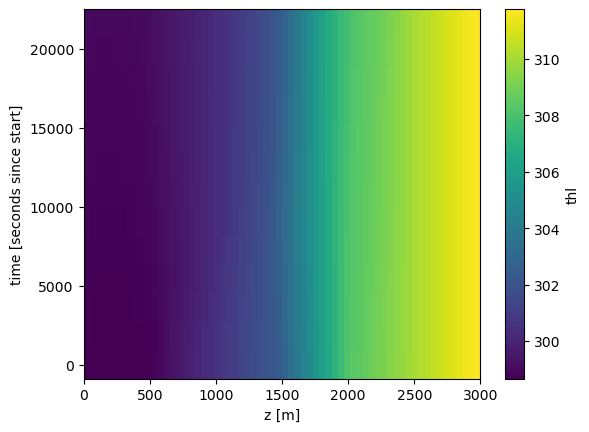

In [12]:
import xarray as xr

ds = xr.open_dataset("thl.nc", decode_times=False)
print(ds)

thl = ds["thl"]
thl.mean(dim=("x","y")).plot()  # example: mean vertical profile


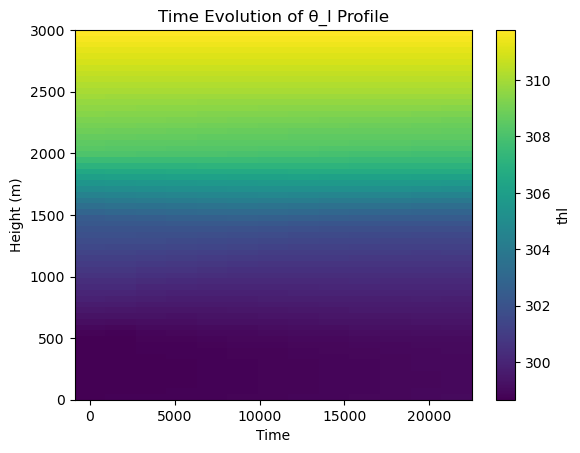

In [23]:
import xarray as xr
import matplotlib.pyplot as plt

# Open NetCDF
ds = xr.open_dataset("thl.nc", decode_times=False)
thl = ds["thl"]   # liquid-water potential temperature

t_profile = thl.mean(dim=("x","y"))  # mean profile

plt.figure()
t_profile.plot(x="time", y="z")
plt.title("Time Evolution of θ_l Profile")
plt.ylabel("Height (m)")
plt.xlabel("Time")
plt.show()



### <span style="color:#FF5733">For u.nc</span>

=== u.nc – Zonal wind (positive = east) ===
Time                : 6.00 h
Mean u below 500 m  : 1.11 m/s
Mean u in cloud layer : 0.31 m/s



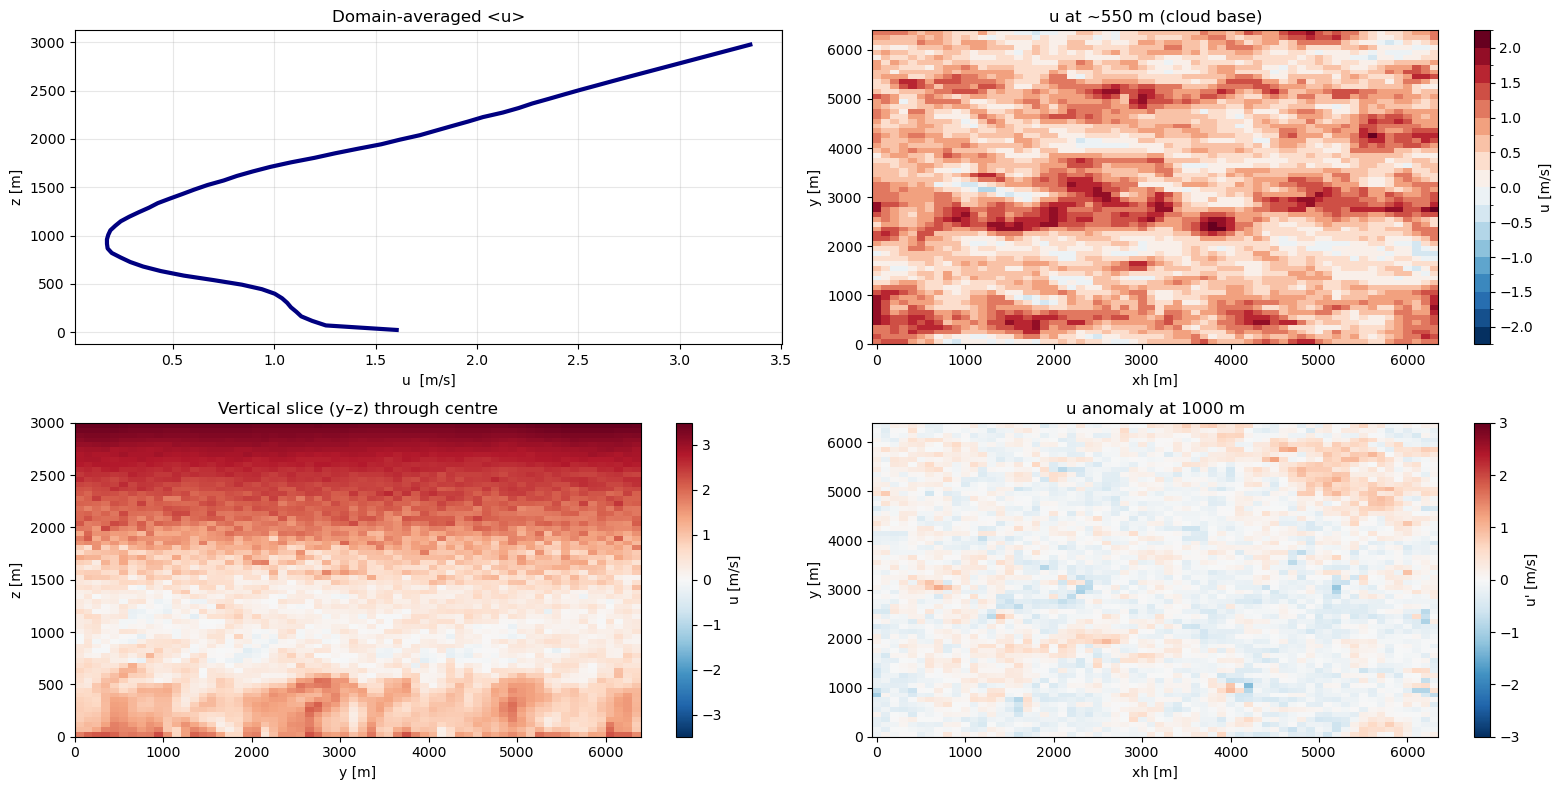

In [24]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Open u.nc
ds = xr.open_dataset('u.nc', decode_times=False)
da = ds[list(ds.data_vars)[0]]          # usually called 'u'
if 'time' in da.dims and len(da.time) > 1:
    da = da.isel(time=-1)
else:
    da = da.squeeze()

print("=== u.nc – Zonal wind (positive = east) ===")
print(f"Time                : {da.time.values.item()/3600:.2f} h")
print(f"Mean u below 500 m  : {da.sel(z=slice(0,500)).mean().item():.2f} m/s")
print(f"Mean u in cloud layer : {da.sel(z=slice(600,1500)).mean().item():.2f} m/s\n")

u = da

plt.figure(figsize=(16,8))

# 1. Vertical profile
plt.subplot(2,2,1)
u.mean(dim=('xh','y')).plot(y='z', color='navy', linewidth=3)
plt.title('Domain-averaged <u>')
plt.xlabel('u  [m/s]')
plt.grid(alpha=0.3)

# 2. Horizontal slice at cloud base
plt.subplot(2,2,2)
u.sel(z=550, method='nearest').plot(cmap='RdBu_r', center=0, levels=21,
                                    cbar_kwargs={'label':'u [m/s]'})
plt.title('u at ~550 m (cloud base)')

# 3. Vertical cross-section (use middle of xh instead of x)
plt.subplot(2,2,3)
middle_xh = u.xh[len(u.xh)//2]
u.sel(xh=middle_xh, method='nearest').plot(cmap='RdBu_r', center=0,
          cbar_kwargs={'label':'u [m/s]'})
plt.title('Vertical slice (y–z) through centre')

# 4. u anomaly at 1000 m
u_mean_prof = u.mean(dim=('xh','y'))
plt.subplot(2,2,4)
(u - u_mean_prof).sel(z=1000, method='nearest').plot(cmap='RdBu_r',
     vmin=-3, vmax=3, center=0,
     cbar_kwargs={'label':"u' [m/s]"})
plt.title('u anomaly at 1000 m')

plt.tight_layout()
plt.show()

### <span style="color:#FF5733">For v.nc</span>

=== v.nc – Meridional wind (positive = north) ===
Time                 : 6.00 h
Domain-averaged |v|  : 0.3875 m/s  ← should be < 0.01
Max |v| in domain    : 2.94 m/s



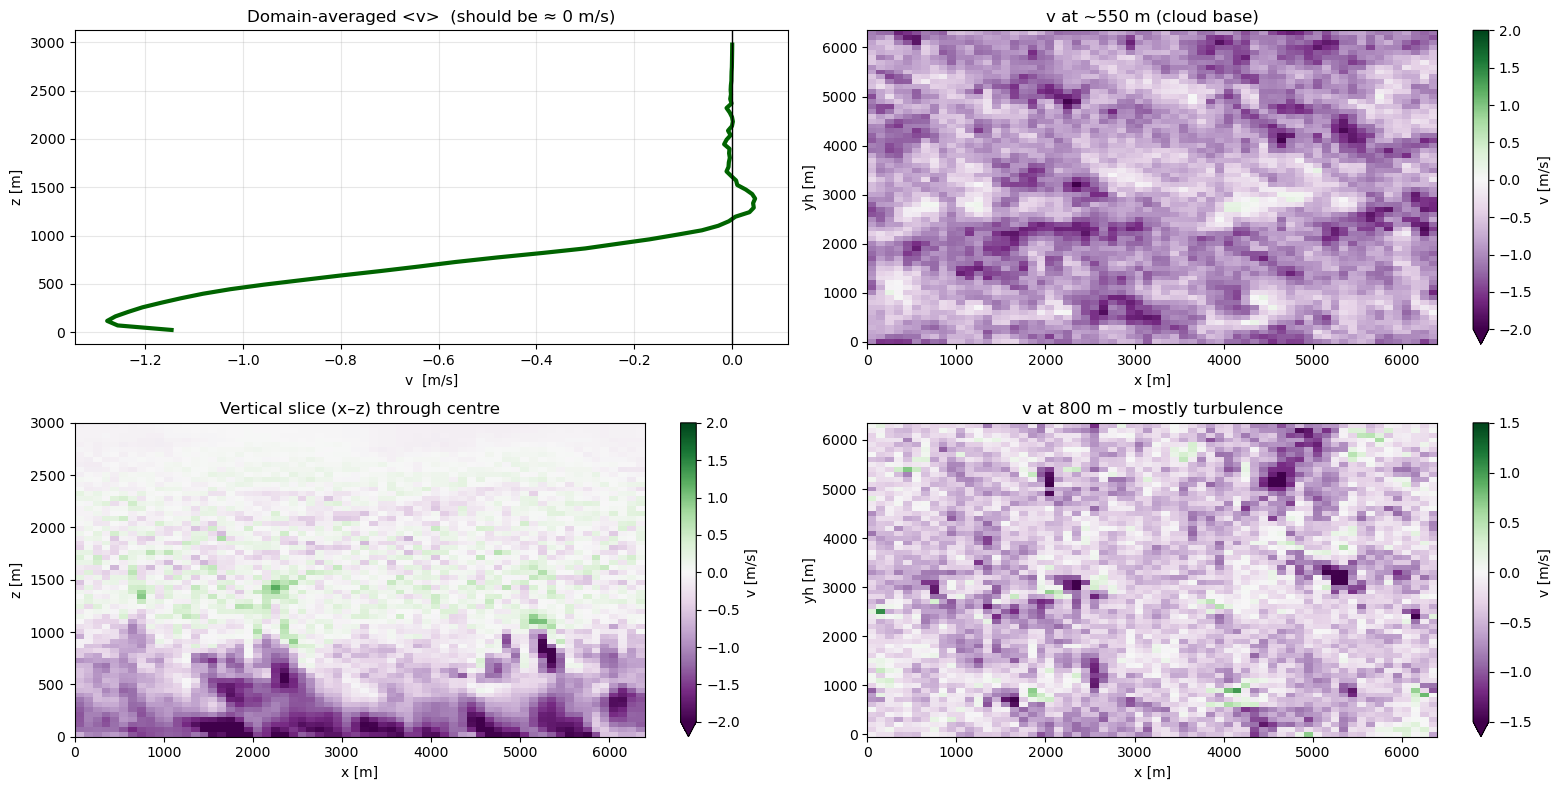

In [25]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Open v.nc
ds = xr.open_dataset('v.nc', decode_times=False)
da = ds[list(ds.data_vars)[0]]          # 'v'
if 'time' in da.dims and len(da.time) > 1:
    da = da.isel(time=-1)
else:
    da = da.squeeze()

print("=== v.nc – Meridional wind (positive = north) ===")
print(f"Time                 : {da.time.values.item()/3600:.2f} h")
print(f"Domain-averaged |v|  : {np.abs(da).mean().item():.4f} m/s  ← should be < 0.01")
print(f"Max |v| in domain    : {np.abs(da).max().item():.2f} m/s\n")

v = da

plt.figure(figsize=(16,8))

# 1. Vertical profile
plt.subplot(2,2,1)
v.mean(dim=('x','yh')).plot(y='z', color='darkgreen', linewidth=3)
plt.axvline(0, color='black', linewidth=1)
plt.title('Domain-averaged <v>  (should be ≈ 0 m/s)')
plt.xlabel('v  [m/s]')
plt.grid(alpha=0.3)

# 2. Horizontal slice at cloud base
plt.subplot(2,2,2)
v.sel(z=550, method='nearest').plot(cmap='PRGn', vmin=-2, vmax=2,
                                    cbar_kwargs={'label':'v [m/s]'})
plt.title('v at ~550 m (cloud base)')

# 3. Vertical cross-section through centre
plt.subplot(2,2,3)
middle_yh = v.yh[len(v.yh)//2]
v.sel(yh=middle_yh, method='nearest').plot(cmap='PRGn', vmin=-2, vmax=2,
          cbar_kwargs={'label':'v [m/s]'})
plt.title('Vertical slice (x–z) through centre')

# 4. v at 800 m – small turbulent structures
plt.subplot(2,2,4)
v.sel(z=800, method='nearest').plot(cmap='PRGn', vmin=-1.5, vmax=1.5,
                                    cbar_kwargs={'label':'v [m/s]'})
plt.title('v at 800 m – mostly turbulence')

plt.tight_layout()
plt.show()

### <span style="color:#FF5733">For w.nc</span>

=== w.nc – Vertical velocity ===
Time                : 6.00 h
Vertical coordinate : zh
Max updraft         : +5.10 m/s
Max downdraft       : -2.04 m/s
RMS w (cloud layer) : 0.30 m/s



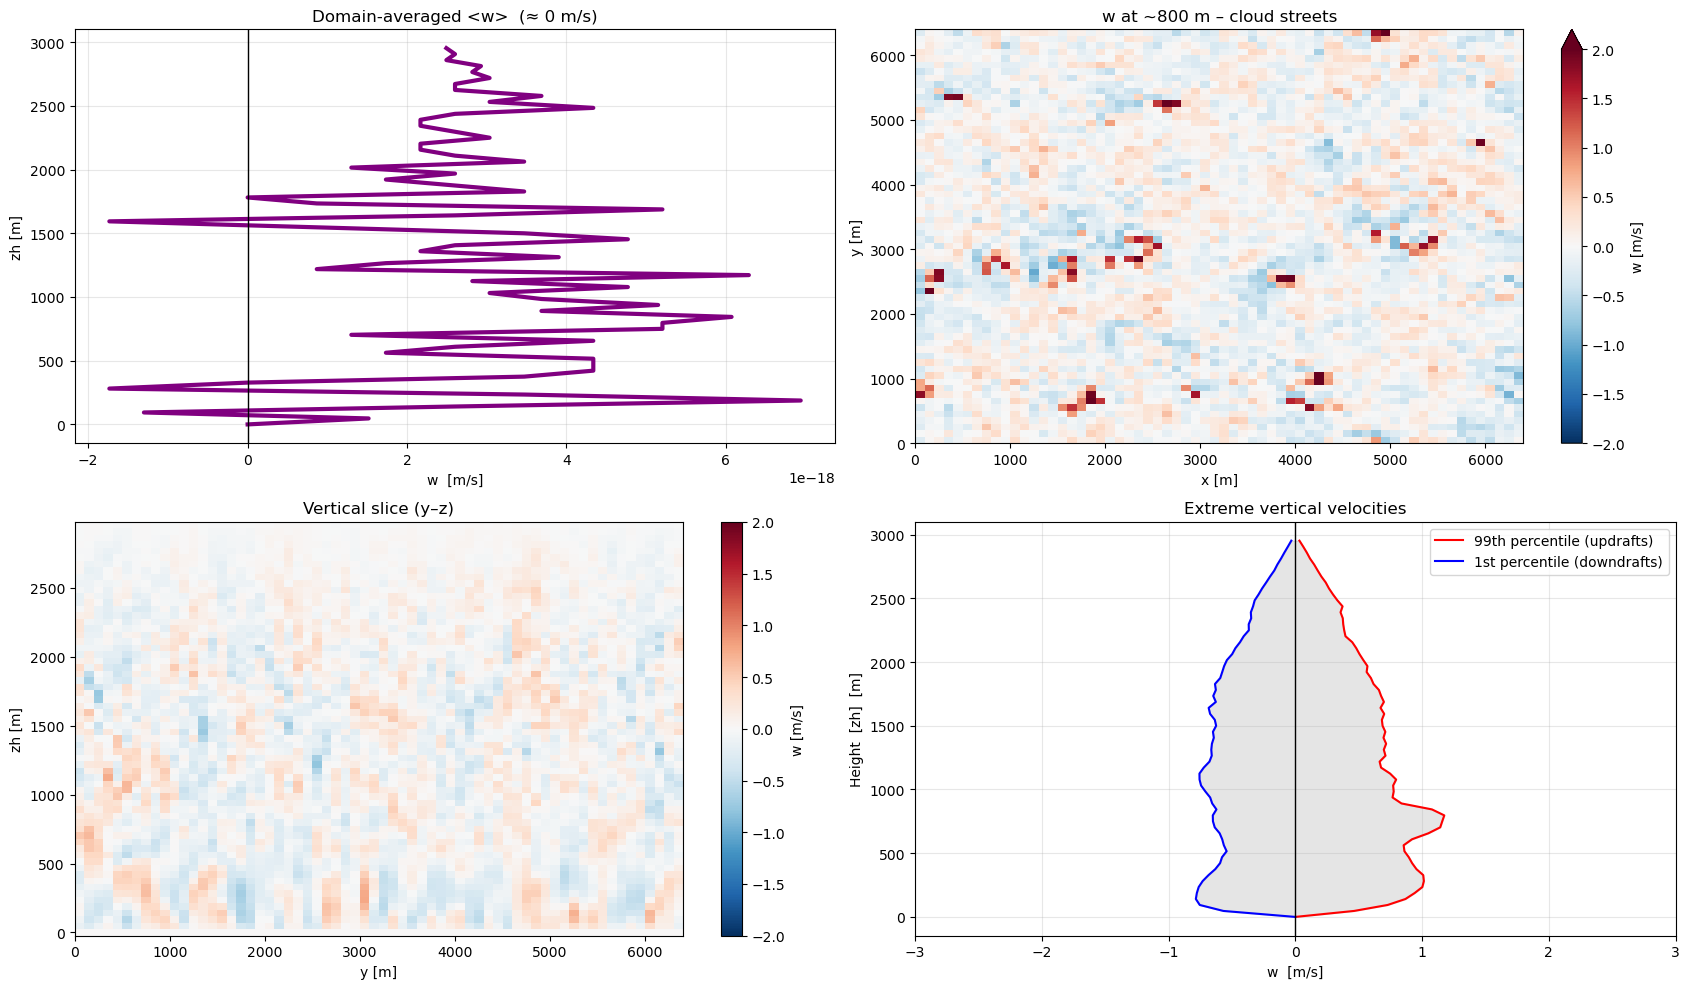

In [26]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Open w.nc
ds = xr.open_dataset('w.nc', decode_times=False)
da = ds[list(ds.data_vars)[0]]          # 'w'

# Take last time step if multiple exist
if 'time' in da.dims and len(da.time) > 1:
    da = da.isel(time=-1)
else:
    da = da.squeeze()

# Detect vertical coordinate: z or zh?
if 'z' in da.dims:
    z_name = 'z'
elif 'zh' in da.dims:
    z_name = 'zh'
else:
    raise KeyError("No vertical coordinate found! Available dims: " + str(list(da.dims)))

z_coord = da[z_name]

print("=== w.nc – Vertical velocity ===")
print(f"Time                : {da.time.values.item()/3600:.2f} h")
print(f"Vertical coordinate : {z_name}")
print(f"Max updraft         : +{da.max().item():.2f} m/s")
print(f"Max downdraft       : {da.min().item():.2f} m/s")
print(f"RMS w (cloud layer) : {da.sel(**{z_name: slice(600,1500)}).std().item():.2f} m/s\n")

w = da

plt.figure(figsize=(17,10))

# 1. Domain-averaged profile
plt.subplot(2,2,1)
w.mean(dim=('x','y')).plot(y=z_name, color='purple', linewidth=3)
plt.axvline(0, color='k', lw=1)
plt.title('Domain-averaged <w>  (≈ 0 m/s)')
plt.xlabel('w  [m/s]')
plt.grid(alpha=0.3)

# 2. Horizontal slice at ~800 m
plt.subplot(2,2,2)
w.sel(**{z_name: 800}, method='nearest').plot(cmap='RdBu_r', vmin=-2, vmax=2, center=0,
                                      cbar_kwargs={'label':'w [m/s]'})
plt.title('w at ~800 m – cloud streets')

#  # 3. Vertical slice through centre
plt.subplot(2,2,3)
middle_x = w.x[len(w.x)//2]
w.sel(x=middle_x, method='nearest').plot(y=z_name, cmap='RdBu_r',
                                         vmin=-2, vmax=2, center=0,
                                         cbar_kwargs={'label':'w [m/s]'})
plt.title('Vertical slice (y–z)')

# 4. Extreme values (99th and 1st percentiles)
plt.subplot(2,2,4)
q99 = w.quantile(0.99, dim=('x','y'))
q01 = w.quantile(0.01, dim=('x','y'))
plt.plot(q99, z_coord, color='red',   label='99th percentile (updrafts)')
plt.plot(q01, z_coord, color='blue',  label='1st percentile (downdrafts)')
plt.fill_betweenx(z_coord, q01, q99, color='gray', alpha=0.2)
plt.axvline(0, color='k', lw=1)
plt.xlim(-3,3)
plt.title('Extreme vertical velocities')
plt.xlabel('w  [m/s]')
plt.ylabel(f'Height  [{z_name}]  [m]')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### <span style="color:#FF5733">Some useful commands for .nc files:</span>

 What times are saved?
ncdump -v time qt.nc

 How big is the file and what variables?
ncdump -h qt.nc | less

 Look at the very first time step (full 3D field)
ncdump -t 0 qt.nc | less

 Extract center column for all times (assuming 256×256 grid)
ncks -d x,128,128 -d y,128,128 qt.nc center_column.nc

 Make a quick time-mean field
ncwa -a time qt.nc qt_timemean.nc

 Make a domain-averaged profile (very common!)
ncwa -a x,y qt.nc qt_profile.nc
ncview qt_profile.nc   # → beautiful mean profile movie

 Compress all your output afterwards (saves tons of disk space)
for f in *.nc; do ncks --deflate 5 -O $f $f; done

# <span style="color: #FF6B6B; font-size: 1.5em">🚀 Code Analysis Summary</span>

## <span style="color: #4ECDC4">What the following Code Calculates</span>

The function computes the **<span style="color: #45B7D1; font-weight: bold">vertical turbulent heat flux

<div style="background: linear-gradient(90deg, #667eea 0%, #764ba2 100%); padding: 15px; border-radius: 10px; color: white; margin: 15px 0;">
<span style="font-size: 1.1em">💡 Values 0.015 & 0.0025 K m s⁻¹ are typical for moderate boundary layer turbulence!</span>
</div>






## <span style="color: #F7DC6F">xarray Code Breakdown</span>

| Operation | Math | Purpose |
|-----------|------|---------|
| `w.mean(['x','y','time'])` | **⟨w⟩** | Mean vertical velocity |
| `thl.mean(['x','y','time'])` | **⟨θl⟩** | Mean potential temp |
| `(w*thl).mean(...)` | **⟨w θl⟩** | Total covariance |
| `flux = cov - mean_w*mean_thl` | **⟨w'θl'⟩** | **Turbulent flux!** |

## <span style="color: #96CEB4">Physical Interpretation</span>

<div style="display: flex; gap: 20px; margin: 20px 0;">
  <div style="flex: 1; background: #E8F5E8; padding: 15px; border-radius: 10px; border-left: 5px solid #4CAF50;">
    <span style="color: #2E7D32; font-weight: bold">✅ Positive = 0.015</span><br>
    **Upward heat transport**<br>
    Warm air rising!
  </div>
  <div style="flex: 1; background: #FFF3E0; padding: 15px; border-radius: 10px; border-left: 5px solid #FF9800;">
    <span style="color: #E65100; font-weight: bold">⚡ 54 W/m²</span><br>
    **ρcₚ × 0.015**<br>
    Moderate heating!
  </div>
</div>

## <span style="color: #E17055">MicroHH Grid Staggering</span>

| Variable | **Grid** | Reason |
|----------|----------|--------|
| `θl, u, v` | <span style="color: #A29BFE">**z** (full)</span> | Scalars |
| `<span style="color: #FF8A80">**w**</span>` | **zh** (half) | Vertical velocity |

<span style="color: #6C5CE7; font-size: 1.2em; font-weight: bold">🎯 Your 0.015 → 0.0025 profile = Classic convective boundary layer decay! ✨</span> 


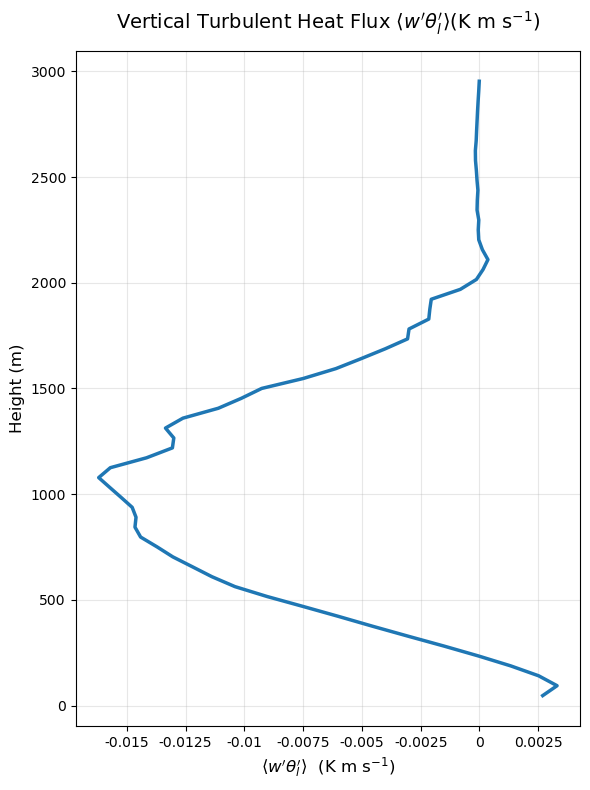

In [37]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def compute_vertical_turbulent_heat_flux(thl_file, w_file):
    """
    Compute the vertical turbulent heat flux profile <w'thl'> from MicroHH NetCDF output files.
    """
    ds_thl = xr.open_dataset(thl_file, decode_times=False)
    ds_w   = xr.open_dataset(w_file,   decode_times=False)
    
    thl = ds_thl['thl']
    w   = ds_w['w']
    
    # Interpolate thl from z → zh levels (half-levels where w is defined)
    thl_interp = thl.interp(z=ds_w['zh'])
    
    # Horizontal (and time) average
    avg_dims = ['x', 'y']
    if 'time' in thl.dims:
        avg_dims.append('time')
    
    mean_w     = w.mean(dim=avg_dims)
    mean_thl   = thl_interp.mean(dim=avg_dims)
    mean_w_thl = (w * thl_interp).mean(dim=avg_dims)
    
    # Turbulent flux: <w'thl'> = <w*thl> - <w><thl>
    flux = mean_w_thl - mean_w * mean_thl
    
    # Attach proper coordinates and attributes
    flux = flux.assign_coords(zh=ds_w['zh'])
    flux.name = "w'thl'"
    flux.attrs['long_name'] = 'Vertical turbulent heat flux'
    flux.attrs['units']     = 'K m s-1'
    
    ds_thl.close()
    ds_w.close()
    
    return flux

# ------------------------------------------------------------------
# Compute and plot
# ------------------------------------------------------------------
flux = compute_vertical_turbulent_heat_flux('thl.nc', 'w.nc')

# Get height coordinate (with units if present)
height = flux['zh']
height_units = height.attrs.get('units', 'm')

plt.figure(figsize=(6, 8))
ax = plt.gca()
flux.plot(y='zh', linewidth=2.5, color='tab:blue', ax=ax)

# Format x-axis to show small decimals clearly (0.015, 0.0025)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.4g}'))
# Alternative: ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))

plt.title(r"Vertical Turbulent Heat Flux $\langle w'\theta_l'\rangle$"
          r"(K m s$^{-1}$)", fontsize=14, pad=15)
plt.xlabel(r"$\langle w'\theta_l'\rangle$  (K m s$^{-1}$)", fontsize=12)
plt.ylabel(f"Height ({height_units})", fontsize=12)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
